In [1]:
using Gadfly, DataFrames, DataArrays, Cairo, Images, ImageMagick, RDatasets, MultivariateStats;

    .==(Images.AbstractImageDirect{Bool, N<:Any}, AbstractArray{Bool, N<:Any}) at /Users/cwestrup/.julia/v0.4/Images/src/algorithms.jl:135
is ambiguous with: 
    .==(AbstractArray{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}}) at /Users/cwestrup/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .==(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}})
before the new definition.
    .==(Images.AbstractImageDirect, AbstractArray) at /Users/cwestrup/.julia/v0.4/Images/src/algorithms.jl:136
is ambiguous with: 
    .==(AbstractArray{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}}) at /Users/cwestrup/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .==(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}

In [2]:
set_default_plot_size(25cm, 20cm);

## Data preparation

We can define the feature variables we'll use:

In [3]:
variables = [:fixedAcidity, :volatileAcidity, :citricAcid, :residualSugar, :chlorides, 
    :freeSulfurDioxide, :totalSulfurDioxide, :density, :pH, :sulphates, :alcohol];
length(variables)

11

Read the data into DataFrames:

In [9]:
df_submission = readtable("data/challenge_public_test_classification_regression_2015.csv", );

In [10]:
df_train = readtable("data/training_classification_regression_2015.csv");

We normalize the features by subtracting from each column its mean and deviding by its standard deviation

In [11]:
df_train_norm = deepcopy(df_train)
for variable in variables
    column = df_train_norm[:, variable]
    df_train_norm[:, variable] = (column .- mean(column)) ./ std(column)
end
df_train_norm;

In [12]:
head(df_train_norm, 1)

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality,_type
1,-0.19581148606307708,-0.3386149588803073,0.5430063966089778,1.6899239900642382,-0.12119819492048489,1.9275660835074595,2.2540949093649036,1.0116150901531629,-0.3105996734319634,0.38998483249693666,-0.8034568236260613,4,White


Stack up the features:

In [13]:
df_train_norm_stacked = stack(df_train_norm, variables);

In [14]:
head(df_train_norm_stacked, 1)

,variable,value,quality,_type
1,fixedAcidity,-0.19581148606307708,4,White



Preparing the data for test / training:

In [17]:
# X = feature DataFrame, Y = target DataFrame
X = df_train_norm[:,1:11]
Y = df_train_norm[:,12:13];

## Functions for cross-validation

A function to generate vectors for splitting the dataset for cross validation each vector selects the datapoints for the test set.

In [21]:
# data_size: data points / rows in dataset
# folds: number of split vectors to be used for CV folds
# test_size_ratio: percentage of dataset to be in test set
function getCVSplits(data_size=5000, folds=5, test_size_ratio=0.25)
    splits = []
    for k in range(1,folds)
        is_train = shuffle(range(1, data_size) .> floor(n * test_size_ratio))
        push!(splits, is_train)
    end
    return splits
end;

A function that splits our dataset with a boolean vector into test and training set:

In [27]:
# splitvectors: boolean vector that selects which entries are in 
#              test/training set, can be obtained using getCVSplits()
# X: feature matrix DataFrame
# Y: target matrix DataFrame
function splitDataset(splitvector, X, Y)
    X_train = X[splitvector,:]
    X_test  = X[!splitvector,:]
    Y_train = Y[splitvector, :]
    Y_test  = Y[!splitvector, :]
    return (X_train, X_test, Y_train, Y_test)
end;

Let's try it out and split the dataset with 0.75 training and 0.25 test data:

In [31]:
# Split for training and test set
n = nrow(X)
splits = getCVSplits(n, 1, 0.25)

# Create dataframes with training and test set:
(X_train, X_test, Y_train, Y_test) = splitDataset(splits[1], X, Y)

println("Total number of datapoints: ",n)
println("Training set size: ", nrow(X_train))
println("Test set size: ", nrow(X_test))

Total number of datapoints: 5000
Training set size: 3750
Test set size: 1250


# Visualizations

## Classification

A placeholder plot we'll use to fill up grids

In [32]:
placeholder = plot(x=[0], y=[0], Guide.xlabel("'placeholder'"));

Plotting all classes for all variables

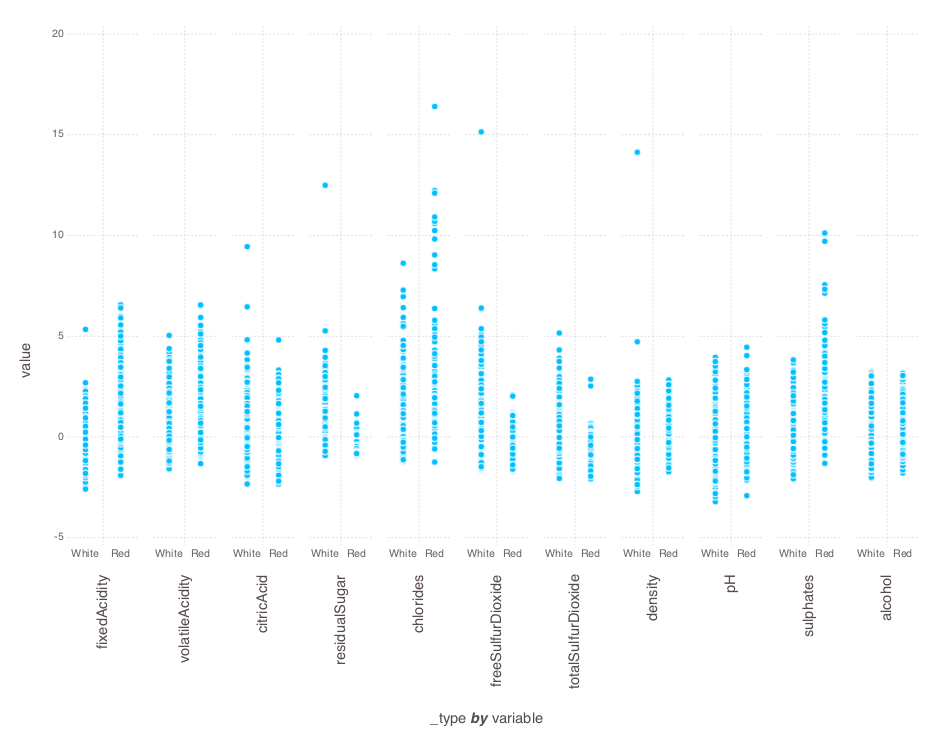

In [45]:
filename = "hist_variables_type"
p = plot(df_train_norm_stacked,
xgroup="variable", x="_type", y="value", Geom.subplot_grid(Geom.point));
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 25cm, 20cm), p)
load(string("plots/", filename, ".png"))

Now each seperately 

In [46]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_train_norm_stacked[df_train_norm_stacked[:variable].==variable, :] 
    push!(plots, plot(feature, x=:_type, y=:value, Geom.point, 
        Guide.xlabel(string(variable), orientation=:horizontal)))
end
push!(plots, placeholder);

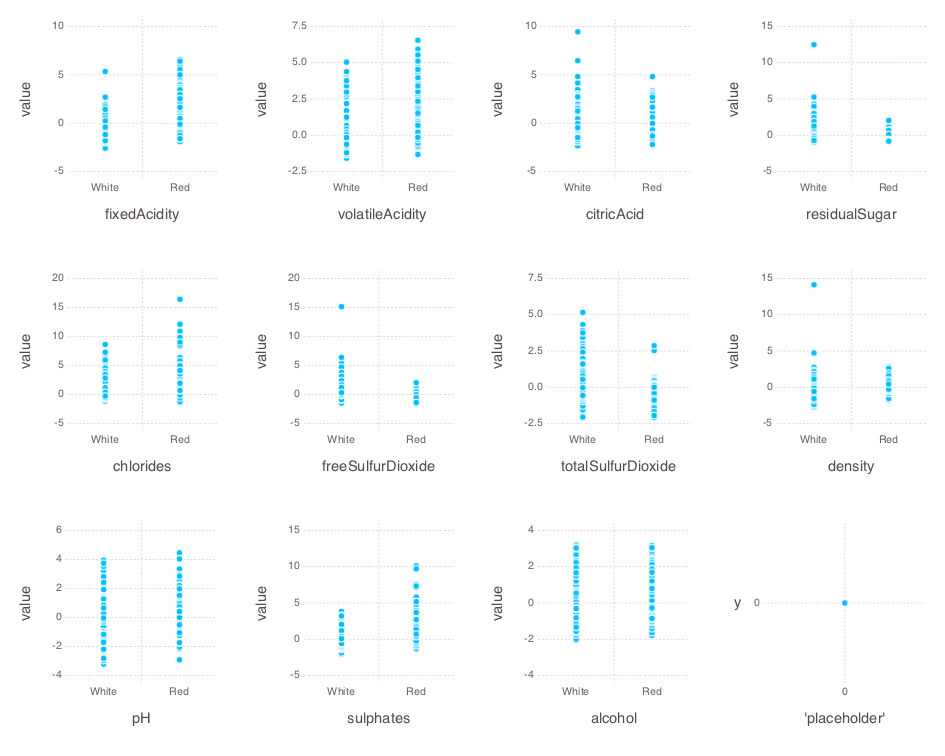

In [47]:
filename = "hist_variables_type_grid"

plotstack = vstack(
    hstack(plots[1], plots[2], plots[3], plots[4]),
    hstack(plots[5], plots[6], plots[7], plots[8]),
    hstack(plots[9], plots[10], plots[11], plots[12]))

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 20cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 20cm), plotstack)
load(string("plots/", filename, ".png"))

The features look somewhat seperable, let's look at the density

In [59]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_train_norm_stacked[df_train_norm_stacked[:variable].==variable, :] 
    push!(plots, plot(feature, color=:_type, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end
push!(plots, placeholder);

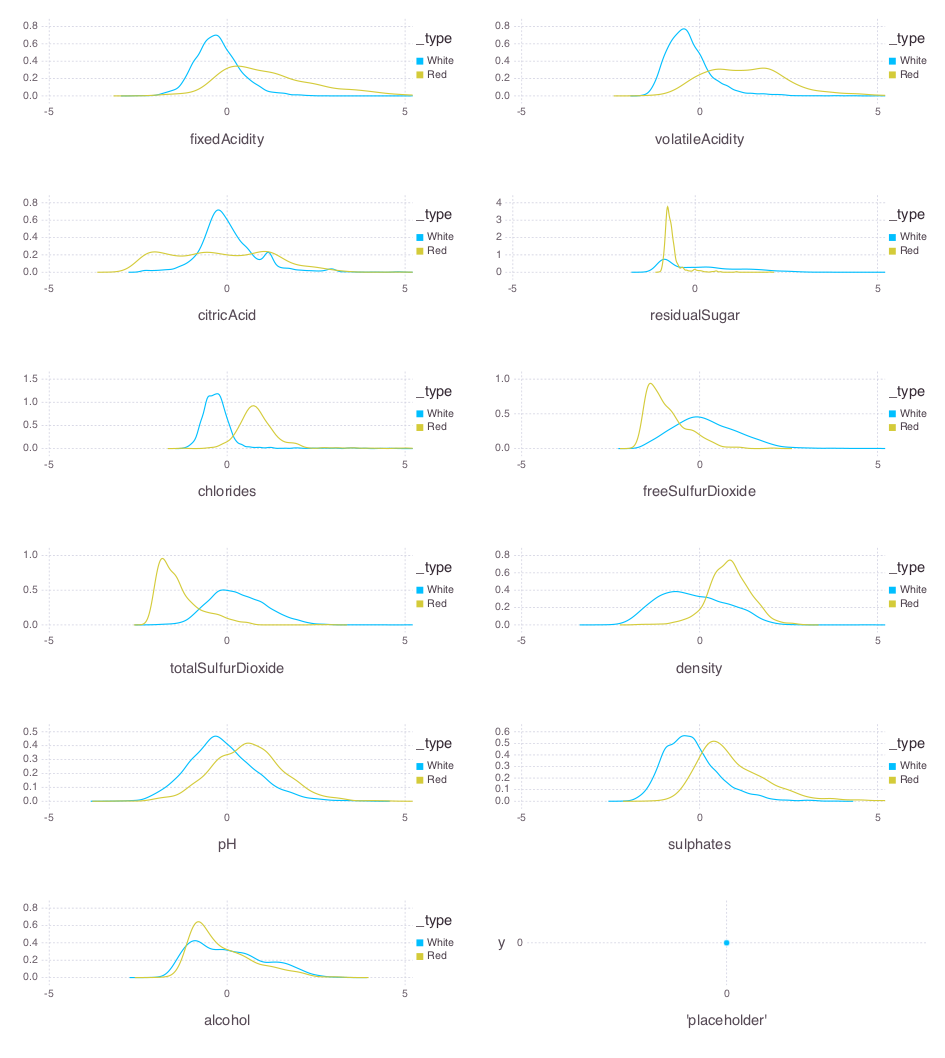

In [60]:
filename = "density_type_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[8]),
    hstack(plots[9], plots[10]),
    hstack(plots[11], plots[12]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 28cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 28cm), plotstack)
load(string("plots/", filename, ".png"))

Seems like there is some pattern here at least...

In [61]:
plots = Gadfly.Plot[]

for variable in variables
    feature = df_train_norm_stacked[df_train_norm_stacked[:variable].==variable, :] 
    
    push!(plots, plot(feature, color=:quality, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end
push!(plots, placeholder);

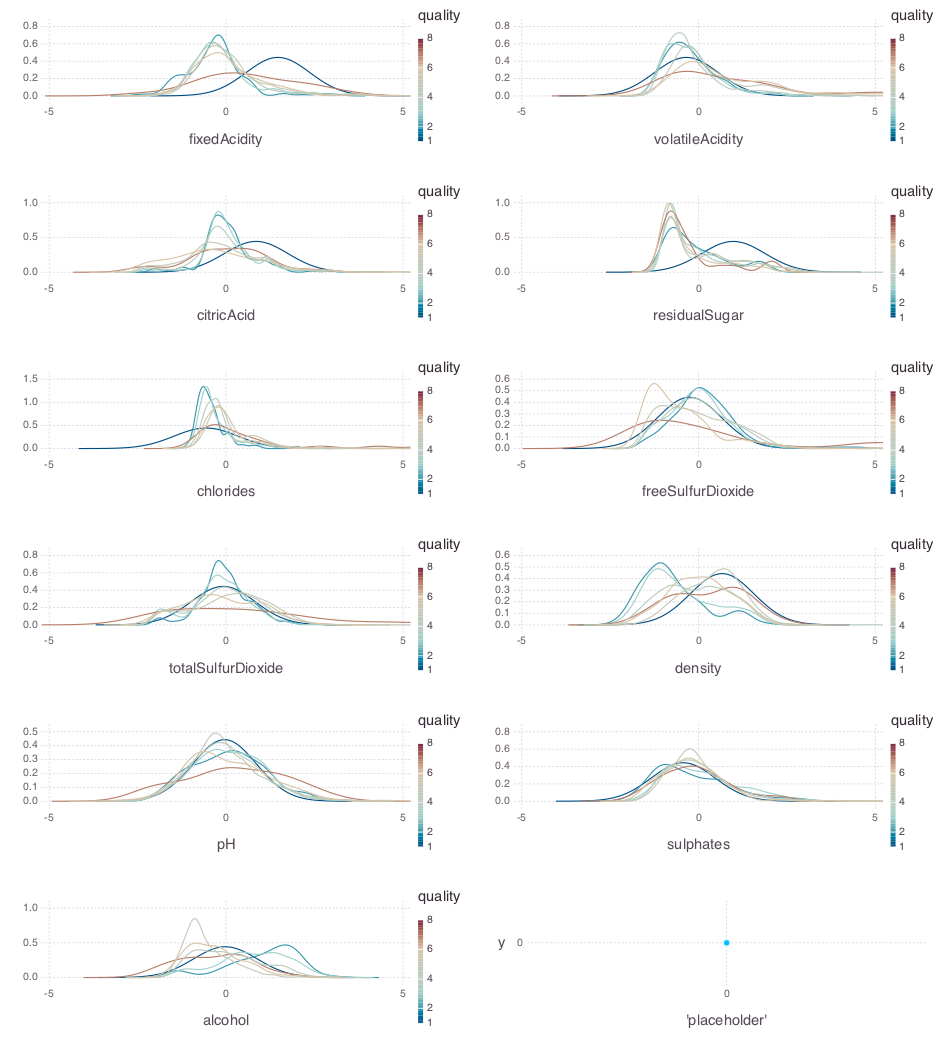

In [62]:
filename = "density_quality_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[8]),
    hstack(plots[9], plots[10]),
    hstack(plots[11], plots[12]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 28cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 28cm), plotstack)
imread(string("plots/", filename, ".png"))

## PCA

In [53]:
# train a PCA model
X_matrix = Matrix(deepcopy(X))
M = fit(PCA, X_matrix'; maxoutdim=15, method=:auto)
pca_matrix = transform(M, X_matrix')';

In [54]:
# make it a DataFrame and merge it with the labels
df_pca = DataFrame(pca_matrix)
df_pca_labelled = hcat(df_pca, Y)
head(df_pca_labelled,1)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,quality,_type
1,-2.7482606232752134,-2.1260445513600894,0.3373770782171445,0.9575492537102434,0.04013838985184908,0.9017164225546604,0.07271211686422652,0.004219083534487509,-0.182775206760877,0.2667753194288211,4,White


Plot first 2 principal components:

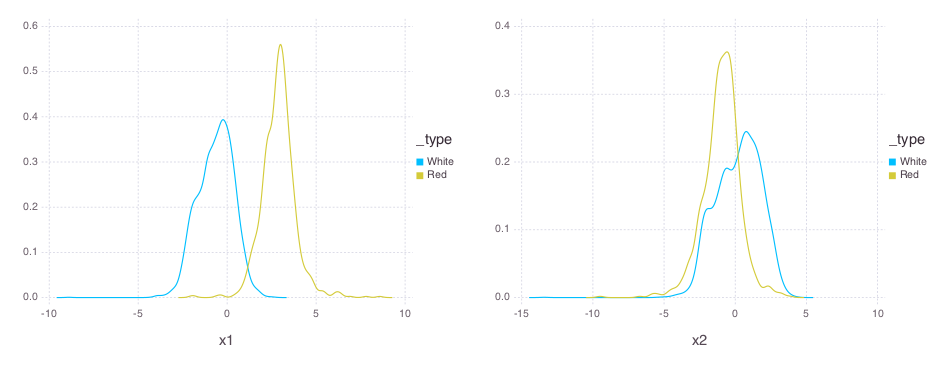

In [63]:
filename = "density_pca_type_2first"
p1 = plot(df_pca_labelled, color=:_type, x=:x1, Geom.density)
p2 = plot(df_pca_labelled, color=:_type, x=:x2, Geom.density)
plotstack = hstack(p1, p2)

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 10cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 10cm), plotstack)
load(string("plots/", filename, ".png"))

First 2 components on a plane

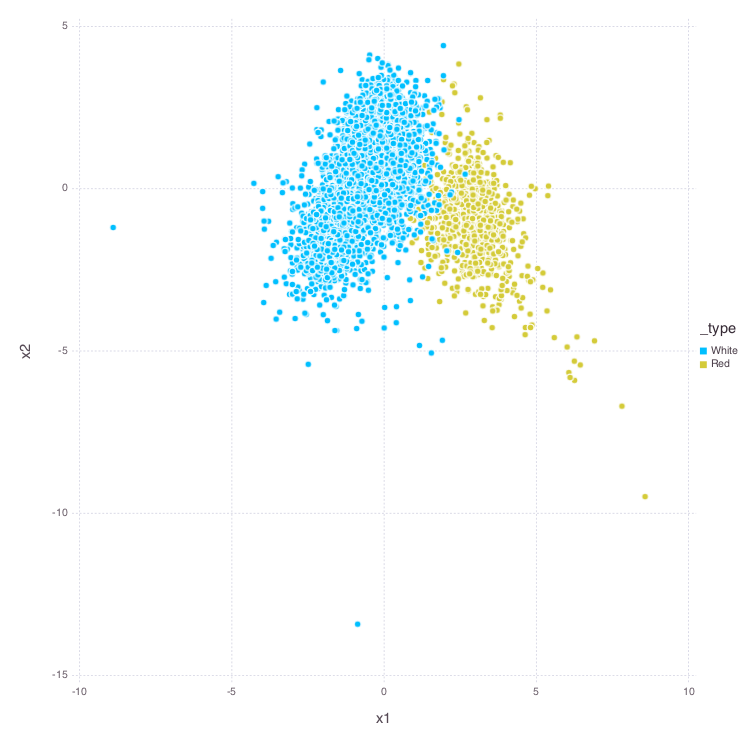

In [57]:
filename = "scatter_pca_type_2first"
p = plot(df_pca_labelled, color=:_type, x=:x1, y=:x2, Geom.point)
draw(PDF(string("plots/", filename, ".pdf"), 20cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 20cm, 20cm), p)
load(string("plots/", filename, ".png"))

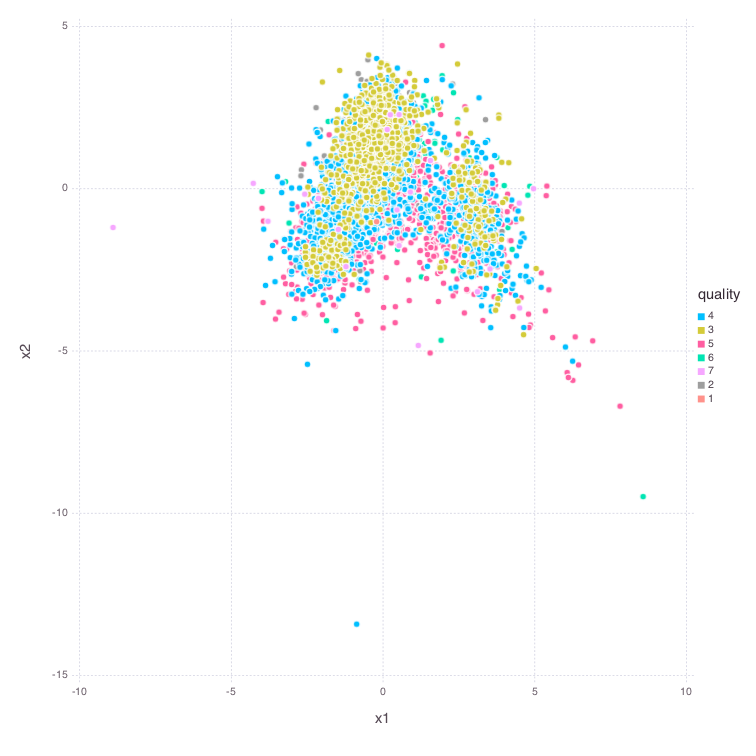

In [64]:
filename = "scatter_pca_quality_2first"
p = plot(df_pca_labelled, color=:quality, x=:x1, y=:x2, Geom.point, Scale.color_discrete())
draw(PDF(string("plots/", filename, ".pdf"), 20cm, 20cm), p)
draw(PNG(string("plots/", filename, ".png"), 20cm, 20cm), p)
load(string("plots/", filename, ".png"))

In [65]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6, :x7, :x8, :x9, :x10]
df_pca_labelled_stacked = stack(df_pca_labelled, variables)

for variable in variables
    feature = df_pca_labelled_stacked[df_pca_labelled_stacked[:variable].==variable, :]     
    push!(plots, plot(feature, color=:quality, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end

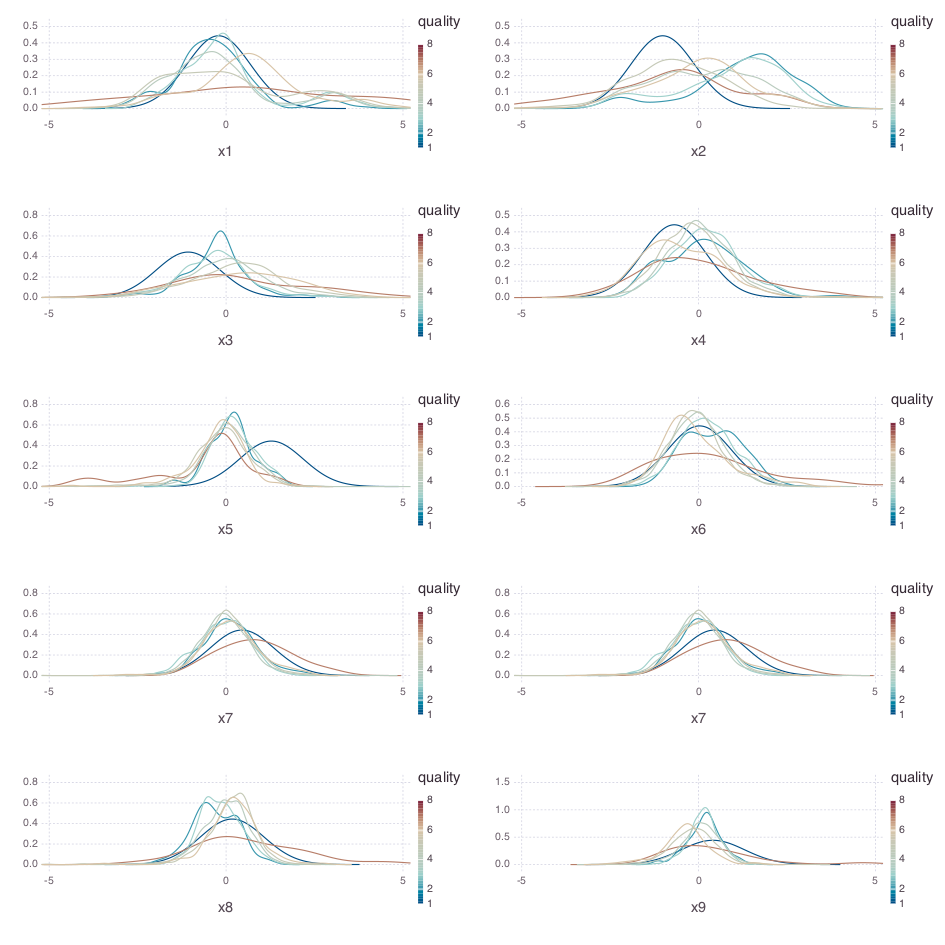

In [66]:
filename = "density_pca_quality_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[7]),
    hstack(plots[8], plots[9]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

In [67]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6, :x7, :x8, :x9, :x10]
df_pca_labelled_stacked = stack(df_pca_labelled, variables)

for variable in variables
    feature = df_pca_labelled_stacked[df_pca_labelled_stacked[:variable].==variable, :]     
    push!(plots, plot(feature, color=:_type, x=:value, Geom.density,
    Guide.xlabel(string(variable), orientation=:horizontal), 
    Coord.cartesian(xmin=-5, xmax=5)))
end

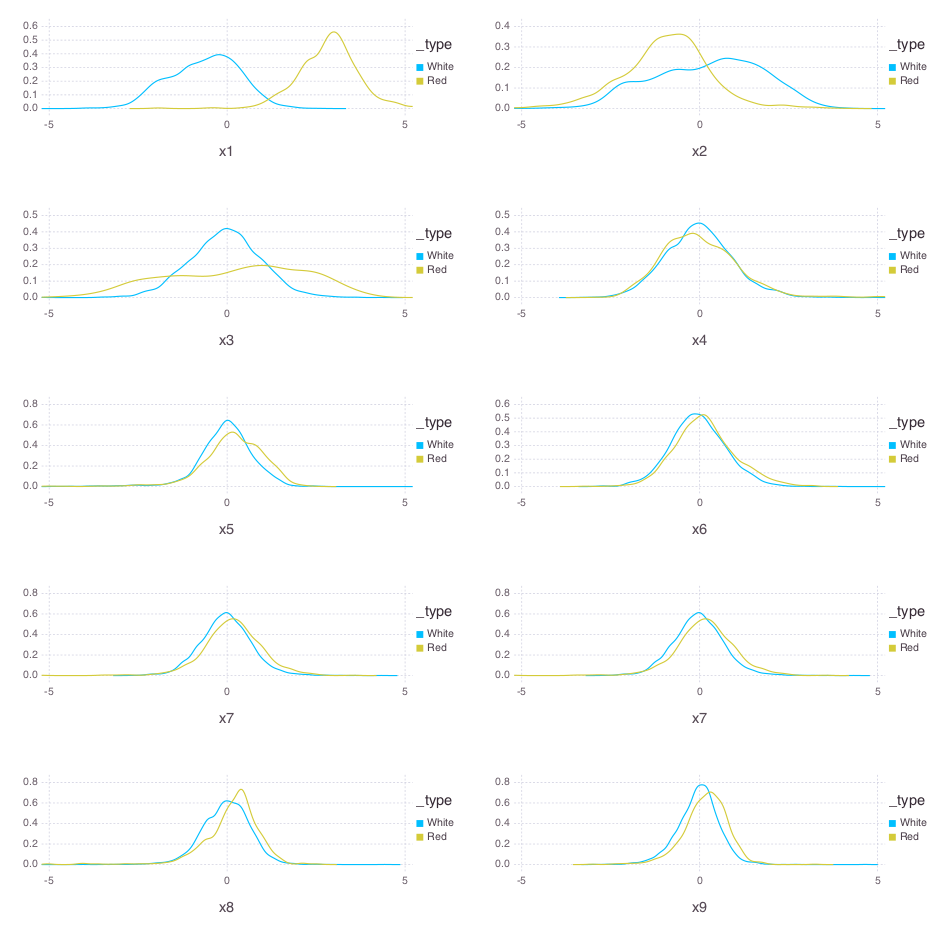

In [68]:
filename = "density_pca_type_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]),
    hstack(plots[7], plots[7]),
    hstack(plots[8], plots[9]))
draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

# ICA

In [69]:
# train a ICA model
X_matrix = Matrix(deepcopy(X))
M = fit(ICA, X_matrix', 6)
ica_matrix = transform(M, X_matrix')';

In [70]:
df_ica = DataFrame(ica_matrix)
labels = df_train[:,12:13]
df_ica_labelled = hcat(df_ica, labels)
head(df_ica_labelled,1)

,x1,x2,x3,x4,x5,x6,quality,_type
1,-0.6835877715229275,-2.217494724940119,-1.0530342494447995,-0.4583924255625204,-0.028743577703455366,-0.04610686531079072,4,White


In [72]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6]
for variable in variables
    push!(plots, plot(df_ica_labelled, color=:_type, x=variable, Geom.density,
        Guide.xlabel(string(variable), orientation=:horizontal)))
end

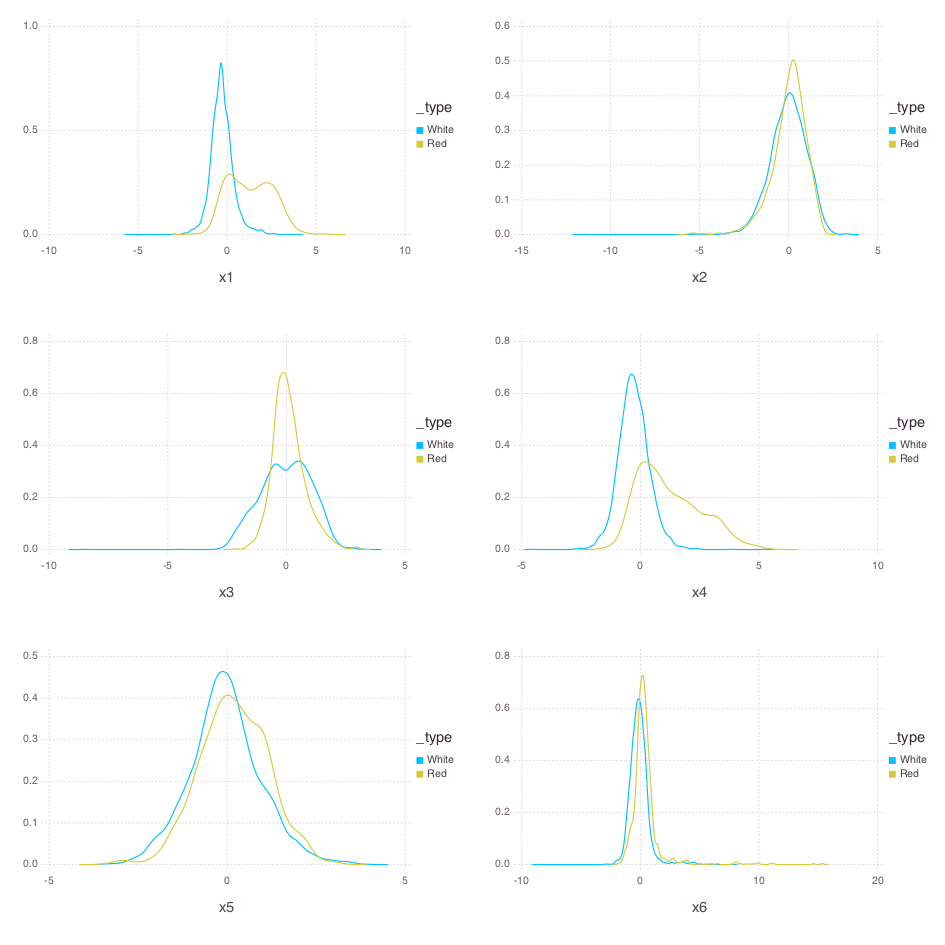

In [73]:
filename = "density_ica_type_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]))

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

In [74]:
plots = Gadfly.Plot[]

variables = [:x1, :x2, :x3, :x4, :x5, :x6]
for variable in variables
    push!(plots, plot(df_ica_labelled, color=:quality, x=variable, Geom.density,
        Guide.xlabel(string(variable), orientation=:horizontal)))
end

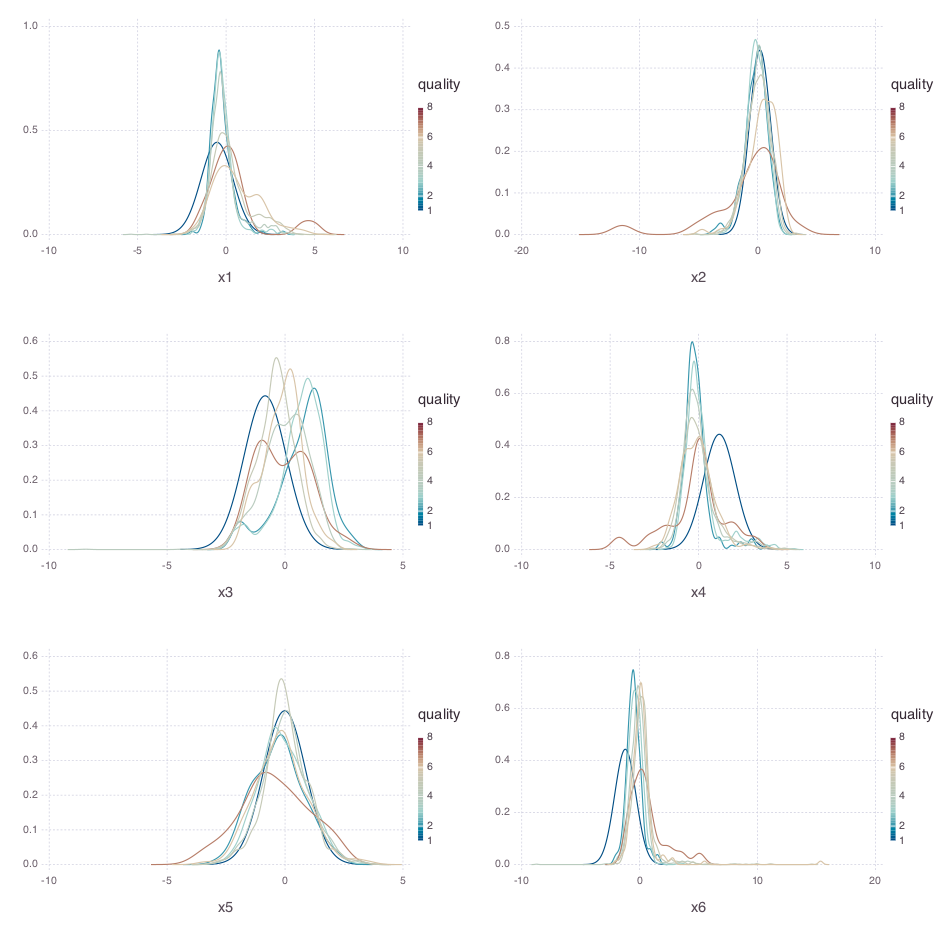

In [75]:
filename = "density_ica_quality_grid"
plotstack = vstack(
    hstack(plots[1], plots[2]),
    hstack(plots[3], plots[4]),
    hstack(plots[5], plots[6]))

draw(PDF(string("plots/", filename, ".pdf"), 25cm, 25cm), plotstack)
draw(PNG(string("plots/", filename, ".png"), 25cm, 25cm), plotstack)
imread(string("plots/", filename, ".png"))

# Linear regression

# Logistic regression

Let's implement logistic regression from scratch to start simple:

$g(x) =  \sum_{i=0}^k w_i Φ_i(x)$, with $Φ_0(x) = 0$

# Neural Network

### Backpropagation:

Number of features is the size of the training set columns, without the id, type and quality columns

In [ ]:
num_of_features = size(df_train,2)-3

Specify the architechture. We'll have a fully connected MLP with 1 hidden layer.

In [ ]:
hidden_layers = 1;
hidden_units = 20;
num_of_outputs = 1;

Initialize the weight matrices randomly

In [ ]:
using Distributions 
θ1 = rand(Uniform(-1, 1), hidden_units + 1, num_of_features + 1);
θ1[1, :] = 1;
θ1

In [ ]:
θ2 = rand(Uniform(-1, 1), num_of_outputs, hidden_units + 1);

In [ ]:
size(θ1), size(θ2)

In [ ]:
x = rand(10)

In [ ]:
x = [1;x]

In [ ]:
tanh(θ1 * x)

In [ ]:
function forwardprop(x,θ)
    tanh(θ ⋅ x)
end